# Lecture 20: Molecular Dynamics Simulations of a Polymer Chain

## Introduction

Polymer chains exhibit fascinating behaviors, including **temperature-driven phase transitions** between folded (globular) and unfolded (extended) states. Understanding these transitions is crucial in fields like biophysics, material science, and nanotechnology. MD simulations provide a powerful tool to study such phenomena at the molecular level.

In this project, you will write a Python program that performs MD simulations of a polymer chain at constant temperature and volume. You will model the polymer as a chain of beads connected by springs and subject to various interaction potentials. By varying parameters such as temperature and interaction strengths, you will simulate and observe the phase transition between the folded and unfolded states of the polymer.

## Polymer Chain Model

### Bead-Spring Model

In the **bead-spring model**, a polymer chain is represented as a series of beads or monomers (red spheres in the figure below) connected by harmonic springs (gray lines). This simple yet effective model captures the essential features of polymer dynamics.

```{figure} bead-spring.png
---
height: 600px
name: polymer_chain_model
---
Schematic of a polymer chain modeled as beads or monomers (red spheres) connected by harmonic springs (gray lines).
```

### Interactions in the Polymer Chain

The interactions in the polymer chain can be categorized as:

1. **Bonded Interactions**: Harmonic potentials between adjacent beads.
2. **Non-Bonded Interactions**:
   - **Excluded Volume Effects**: Repulsive Lennard-Jones (LJ) potential between beads separated by one spacer.
   - **Attractive Interactions**: LJ potential between beads separated by more than one spacer.

### Potential Energy Components

#### Harmonic Bond Potential and Forces

The harmonic bond potential between adjacent beads is given by

$$
U_{\text{bond}}(r) = \frac{1}{2} k (r - r_0)^2
$$

where $k$ is the spring constant, $r$ is the distance between two adjacent beads, and $r_0$ is the equilibrium bond length.

The force due to the harmonic bond potential is

$$
\mathbf{F}_{\text{bond}} = -\frac{dU_{\text{bond}}}{dr} = -k (r - r_0) \hat{\mathbf{r}}
$$

where $\hat{\mathbf{r}}$ is the unit vector along the bond direction.

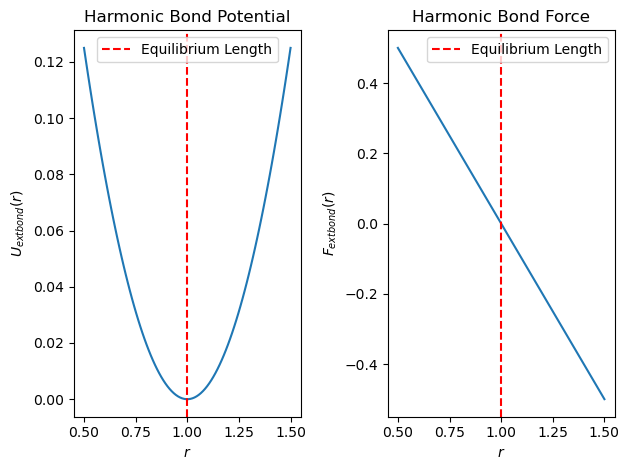

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Harmonic bond potential
def harmonic_bond_potential(r, k, r0):
    return 0.5 * k * (r - r0)**2

# Harmonic bond force
def harmonic_bond_force(r, k, r0):
    return -k * (r - r0)

# Parameters
k = 1.0
r0 = 1.0
r_values = np.linspace(0.5, 1.5, 100)
U_values = harmonic_bond_potential(r_values, k, r0)
F_values = harmonic_bond_force(r_values, k, r0)

# Plot
fig, axs = plt.subplots(1, 2)
axs[0].plot(r_values, U_values)
axs[0].axvline(x=r0, color='r', linestyle='--', label='Equilibrium Length')
axs[0].set_xlabel('$r$')
axs[0].set_ylabel('$U_{\text{bond}}(r)$')
axs[0].set_title('Harmonic Bond Potential')
axs[0].legend()
axs[1].plot(r_values, F_values)
axs[1].axvline(x=r0, color='r', linestyle='--', label='Equilibrium Length')
axs[1].set_xlabel('$r$')
axs[1].set_ylabel('$F_{\text{bond}}(r)$')
axs[1].set_title('Harmonic Bond Force')
axs[1].legend()
plt.tight_layout()
plt.show()

#### Lennard-Jones Potential

The repulsive LJ potential models excluded volume effects between beads separated by one spacer ($i, i+2$)

$$
U_{\text{LJ,rep}}(r) =
\begin{cases}
4\epsilon_{\text{rep}} \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^6 + \frac{1}{4} \right], & r < 2^{1/6} \sigma, \\
0, & r \geq 2^{1/6} \sigma.
\end{cases}
$$

The attractive LJ potential models interactions between beads separated by more than one spacer ($|i - j| > 2$)

$$
U_{\text{LJ,att}}(r) = 4\epsilon_{\text{att}} \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^6 \right]
$$

where $\epsilon_{\text{rep}}$ and $\epsilon_{\text{att}}$ are the depth of the repulsive and attractive potentials, respectively, and $\sigma$ is the LJ potential parameter.

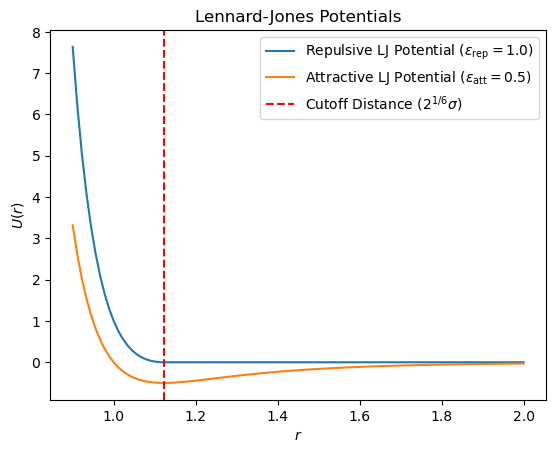

In [2]:
# Lennard-Jones potentials
def lj_repulsive_potential(r, epsilon, sigma):
    potential = np.zeros_like(r)
    mask = r < 2**(1/6) * sigma
    potential[mask] = 4 * epsilon * ((sigma / r[mask])**12 - (sigma / r[mask])**6 + 0.25)
    return potential

def lj_attractive_potential(r, epsilon, sigma):
    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

# Parameters
epsilon_repulsive = 1.0
epsilon_attractive = 0.5
sigma = 1.0
r_values = np.linspace(0.9, 2.0, 100)
U_repulsive_values = lj_repulsive_potential(r_values, epsilon_repulsive, sigma)
U_attractive_values = lj_attractive_potential(r_values, epsilon_attractive, sigma)

# Plot
plt.figure()
plt.plot(r_values, U_repulsive_values, label='Repulsive LJ Potential ($\epsilon_{\\text{rep}} = 1.0$)')
plt.plot(r_values, U_attractive_values, label='Attractive LJ Potential ($\epsilon_{\\text{att}} = 0.5$)')
plt.axvline(x=2**(1/6) * sigma, color='r', linestyle='--', label='Cutoff Distance ($2^{1/6} \sigma$)')
plt.xlabel('$r$')
plt.ylabel('$U(r)$')
plt.title('Lennard-Jones Potentials')
plt.legend()
plt.show()

### Total Potential Energy

The total potential energy of the system is:

$$
U_{\text{total}} = \sum_{\text{bonds}} U_{\text{bond}}(r_{i,i+1}) + \sum_{\substack{i,j \\ |i-j|=2}} U_{\text{LJ,rep}}(r_{ij}) + \sum_{\substack{i,j \\ |i-j|>2}} U_{\text{LJ,att}}(r_{ij})
$$

where $r_{ij}$ is the distance between beads $i$ and $j$ and $U_{\text{LJ,rep}}$ and $U_{\text{LJ,att}}$ are the repulsive and attractive LJ potentials, respectively.

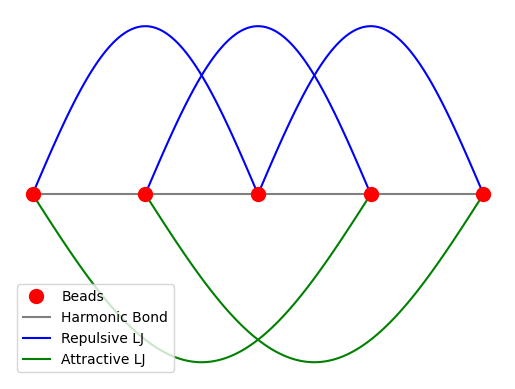

In [3]:
plt.figure()

# Plot beads as red circles
plt.plot([0, 1, 2, 3, 4], [0, 0, 0, 0, 0], 'ro', markersize=10, label='Beads')

# Plot harmonic bonds as gray lines
plt.plot([0, 1], [0, 0], 'C7-', label='Harmonic Bond', zorder=0)
plt.plot([1, 2], [0, 0], 'C7-', zorder=0)
plt.plot([2, 3], [0, 0], 'C7-', zorder=0)
plt.plot([3, 4], [0, 0], 'C7-', zorder=0)

# Plot repulsive LJ interactions as blue curves
x02 = np.linspace(0, 2, 100)
x13 = np.linspace(1, 3, 100)
x24 = np.linspace(2, 4, 100)
curve = np.sin(x02 * np.pi / 2)
plt.plot(x02, curve, 'b-', label='Repulsive LJ', zorder=1)
plt.plot(x13, curve, 'b-', zorder=1)
plt.plot(x24, curve, 'b-', zorder=1)

# Plot attractive LJ interactions as green curves
x03 = np.linspace(0, 3, 100)
x14 = np.linspace(1, 4, 100)
curve = -np.sin(x03 * np.pi / 3)
plt.plot(x03, curve, 'g-', label='Attractive LJ', zorder=1)
plt.plot(x14, curve, 'g-', zorder=1)

plt.axis('off')
plt.legend()
plt.show()

## Temperature Control

To simulate at constant temperature, a simple **velocity rescaling** thermostat is used.

1. Compute instantaneous temperature:

   $$
   T_{\text{inst}} = \frac{2 K}{3 N k_B}
   $$

   where $K$ is the total kinetic energy, $N$ is the number of particles, and $k_B$ is the Boltzmann constant.

2. Rescale velocities:

   $$
   \mathbf{v}_i \leftarrow \mathbf{v}_i \sqrt{\frac{T_{\text{target}}}{T_{\text{inst}}}}
   $$

```{warning}
The velocity rescaling thermostat does not provide true canonical ensemble sampling. More advanced thermostats like Nosé-Hoover dynamics are used for more accurate temperature control.
```

## Pseudocode for MD Simulation of Polymer Chain

### Initialize Positions and Velocities

```none
FUNCTION initialize_chain(n_particles, box_size, r0):
    positions = array of zeros with shape (n_particles, 3)
    current_position = [box_size/2, box_size/2, box_size/2]
    positions[0] = current_position
    FOR i FROM 1 TO n_particles - 1:
        direction = random unit vector
        next_position = current_position + r0 * direction
        positions[i] = apply_pbc(next_position, box_size)
        current_position = positions[i]
    RETURN positions

FUNCTION initialize_velocities(n_particles, target_temperature, mass):
    velocities = random velocities from Maxwell-Boltzmann distribution
    velocities -= mean(velocities)  # Remove net momentum
    RETURN velocities
```

The `initialize_chain` function works like placing segments of a "Snake" in the classic video game (see image below), starting from the center of the screen (simulation box) and extending outward. Each segment of the snake is added by moving a fixed distance (`r0`, like the snake's body length) in a random direction from the previous segment. If the snake crosses the screen boundaries, it wraps around to the opposite side, mimicking periodic boundary conditions. This ensures the snake stays within the screen while maintaining its shape and continuity. The result is a randomly oriented snake with evenly spaced segments, ready for dynamic movement in the simulation.

```{figure} snake_trs-80.jpg
---
height: 200px
name: snake_game
---
Classic Snake Game
```

### Apply Periodic Boundary Conditions

```none
FUNCTION apply_pbc(position, box_size):
    RETURN position modulo box_size
```

### Compute Forces

#### Harmonic Forces

```none
FUNCTION compute_harmonic_forces(positions, k, r0, box_size):
    forces = zeros_like(positions)
    FOR i FROM 0 TO n_particles - 2:
        displacement = positions[i+1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i+1] += force
    RETURN forces
```

#### Lennard-Jones Forces

```none
FUNCTION compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = zeros_like(positions)
    FOR i FROM 0 TO n_particles - 1:
        FOR j FROM i+1 TO n_particles - 1:
            IF interaction_type == 'repulsive' AND |i - j| == 2:
                USE epsilon_repulsive
            ELSE IF interaction_type == 'attractive' AND |i - j| > 2:
                USE epsilon_attractive
            ELSE:
                CONTINUE
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = norm(displacement)
            IF distance < cutoff:
                force_magnitude = 24 * epsilon * [ (sigma / distance)^{12} - 0.5 * (sigma / distance)^6 ] / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    RETURN forces
```

### Velocity Verlet Integration

```none
FUNCTION velocity_verlet(positions, velocities, forces, dt, mass):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    forces_new = compute_forces(positions)
    velocities += 0.5 * forces_new / mass * dt
    RETURN positions, velocities, forces_new
```

### Velocity Rescaling Thermostat

```none
FUNCTION rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * sum(norm(velocities, axis=1)^2)
    current_temperature = (2/3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    RETURN velocities
```

## Example Simulation

Here is an example Python code snippet that performs an MD simulation of a polymer chain using the bead-spring model with Lennard-Jones interactions.

```python
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
dt = 0.01  # Time step
total_steps = 10000  # Number of steps
box_size = 100.0  # Size of the cubic box
k = 1.0  # Spring constant
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
target_temperature = 0.1  # Target temperature
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter

# Initialize positions and velocities
positions = initialize_chain(n_particles, box_size, r0)
velocities = initialize_velocities(n_particles, target_temperature, mass)

# Simulation loop
for step in range(total_steps):
    # Compute forces
    forces_harmonic = compute_harmonic_forces(positions, k, r0, box_size)
    forces_repulsive = compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive')
    forces_attractive = compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    total_forces = forces_harmonic + forces_repulsive + forces_attractive
    
    # Integrate equations of motion
    positions, velocities, total_forces = velocity_verlet(positions, velocities, total_forces, dt, mass)
    
    # Apply thermostat
    if step % rescale_interval == 0:
        velocities = rescale_velocities(velocities, target_temperature, mass)
    
    # (Optional) Store data for analysis
    # ...

# Plot results
# (Plotting code goes here)
```

## Project Description

### Scenario

You are a chemical scientist at a space technology company dedicated to developing advanced materials for spacecraft. One of the challenges in space is the extreme temperatures, which can cause polymer materials to fold or become brittle, compromising their mechanical properties and reliability. Your team aims to design polymer materials that remain unfolded and maintain their structural integrity at the low temperatures encountered in space environments.

Your task is to simulate a polymer chain using molecular dynamics to understand how temperature affects its conformational behavior, with a focus on preventing folding at low temperatures. You will model the polymer chain as a series of beads connected by harmonic springs and include non-bonded interactions using Lennard-Jones potentials. By performing simulations at various space-relevant temperatures, you will analyze properties such as the radius of gyration, end-to-end distance, and potential energy to assess the linearity and stability of the polymer chain. Your findings will contribute to the design of polymers suitable for use in space technology.

Finally, you will write a report summarizing your findings and discussing the implications for material design in the context of space applications.

### Tasks

- Implement an MD simulation of a polymer chain using the bead-spring model.
- Include harmonic bond potentials and Lennard-Jones non-bonded interactions.
- Simulate the polymer at different temperatures.
- Calculate and analyze properties such as radius of gyration, end-to-end distance, and potential energy.
- Observe and characterize the phase transition between folded and unfolded states.
- Write a report summarizing your findings.

### Requirements

#### Implementation

- **Initialize Positions**: Generate an initial configuration of the polymer chain without overlaps, applying periodic boundary conditions.
- **Compute Forces**: Implement functions to calculate harmonic bond forces and Lennard-Jones forces (both repulsive and attractive).
- **Integrate Equations of Motion**: Use the velocity Verlet algorithm to update positions and velocities.
- **Temperature Control**: Implement a thermostat using velocity rescaling to maintain constant temperature.
- **Data Collection**: Store trajectories and compute properties for analysis.

#### Simulation Parameters

- **Polymer Length**: Use at least $N = 20$ beads.
- **Temperature Range**: Simulate at temperatures ranging from low to high (e.g., $T = 0.1$ to $T = 1.0$).
- **Interaction Strengths**: Identify values of $k$ and $\epsilon_{\text{repulsive}}$ that prevent folding at low temperatures. Use $\epsilon_{\text{attractive}} = 0.5$ and $\sigma = 1.0$.

#### Analysis

- **Radius of Gyration ($R_g$)**:

  $$
  R_g = \sqrt{\frac{1}{N} \sum_{i=1}^N (\mathbf{r}_i - \mathbf{r}_{\text{cm}})^2}
  $$

  where $\mathbf{r}_{\text{cm}}$ is the center of mass of the polymer.

- **End-to-End Distance ($R_{\text{ee}}$)**:

  $$
  R_{\text{ee}} = |\mathbf{r}_N - \mathbf{r}_1|
  $$

- **Potential Energy**: Analyze how the potential energy changes with temperature.

- **Phase Transition**: Identify the temperature at which the polymer transitions from folded to unfolded state.

#### Visualization

- Plot $R_g$, $R_{\text{ee}}$, and potential energy as functions of temperature.
- Visualize the polymer configurations at different temperatures.
- Optionally, create animations of the polymer dynamics using, *e.g.*, ASE or Matplotlib.

#### Report

- **Introduction**: Briefly explain the significance of polymer folding and the purpose of your simulation.
- **Methods**: Describe your simulation setup, including models and algorithms used.
- **Results**: Present your findings with plots and figures.
- **Discussion**: Interpret your results, discussing the phase transition and its implications.
- **Conclusion**: Summarize your study and suggest future work.

### Optional Enhancements (Five Bonus Points Each)

- **Chain Length Effects**: Investigate how the length of the polymer chain affects the folding behavior.
- **Energy Minimization**: Perform energy minimization before starting the MD simulation to find a stable initial configuration.

## Pseudocode for Analysis Functions

### Calculate Radius of Gyration

```none
FUNCTION calculate_radius_of_gyration(positions):
    center_of_mass = mean(positions, axis=0)
    Rg_squared = mean(sum((positions - center_of_mass)^2, axis=1))
    Rg = sqrt(Rg_squared)
    RETURN Rg
```

### Calculate End-to-End Distance

```none
FUNCTION calculate_end_to_end_distance(positions):
    Ree = norm(positions[-1] - positions[0])
    RETURN Ree
```

## Example Analysis Code

```python
# Arrays to store properties
temperatures = np.linspace(0.1, 1.0, 10)
Rg_values = []
Ree_values = []
potential_energies = []

for T in temperatures:
    # Set target temperature
    target_temperature = T
    # (Re-initialize positions and velocities)
    # (Run simulation)
    # Compute properties
    Rg = calculate_radius_of_gyration(positions)
    Ree = calculate_end_to_end_distance(positions)
    Rg_values.append(Rg)
    Ree_values.append(Ree)
    potential_energies.append(np.mean(potential_energy_array))

# Plotting
plt.figure()
plt.plot(temperatures, Rg_values, label='Radius of Gyration')
plt.xlabel('Temperature')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Temperature')
plt.legend()
plt.show()

plt.figure()
plt.plot(temperatures, Ree_values, label='End-to-End Distance')
plt.xlabel('Temperature')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Temperature')
plt.legend()
plt.show()

plt.figure()
plt.plot(temperatures, potential_energies, label='Potential Energy')
plt.xlabel('Temperature')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Temperature')
plt.legend()
plt.show()
```

## Project Submission

- **Code**: Submit your Python code implementing the MD simulation and analysis.
- **Report**: Submit a PDF report containing your findings, plots, and discussions.
- **Repository**: Push your code and report to the project repository on GitHub.
- **Submission Link**: Provide the repository link to the course portal.